In [1]:
import datetime as dt
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from pandas.api.types import CategoricalDtype

sns.set_style('white')
# sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [3]:
df = pd.read_csv('./data/bikeshare_ridership.csv')
df.columns = [' '.join(x.replace('trip_', '').replace('_seconds', '').split('_')).title() for x in df.columns]

In [4]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['Start Time'] = df['Start Time'].apply(lambda x: x - dt.timedelta(hours=4) if x.month < 7 else x)

df['Date'] = df['Start Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['Start Time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['Start Time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['Start Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['Start Time'].apply(lambda x: x.strftime('%H'))

df['Route Id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['Station Id From']), int(x['Station Id To'])), axis=1)

In [5]:
df = df[(~df['Lat To'].isna())&(~df['Lat From'].isna())]

In [6]:
maps = df[['Route Id', 'Station Id From', 'Lat From', 'Lon From', 'Station Id To', 'Lat To', 'Lon To']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['Lat From'], x['Lon From']), (x['Lat To'], x['Lon To'])).km * 1000, axis=1)

In [7]:
df = df.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
df = df[[x for x in df.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

In [8]:
df.sample(10)

,Id,Start Time,Duration,User Type,Date,Quarter,Month,Day of Week,Hour,Distance
610460,1373087,2017-07-17 16:54:00,896,Member,2017-07-17,3,July,Mon,16,2091.038159
1002919,1706323,2017-08-29 14:57:00,673,Casual,2017-08-29,3,August,Tue,14,2224.735216
923888,751490,2017-01-25 17:07:00,544,Member,2017-01-25,1,January,Wed,17,1949.465419
1213252,1410372,2017-07-21 22:15:00,906,Casual,2017-07-21,3,July,Fri,22,1339.400839
532840,2048763,2017-10-12 08:25:04,649,Member,2017-10-12,4,October,Thu,08,1673.558340
963708,779316,2017-02-13 09:20:00,1319,Member,2017-02-13,1,February,Mon,09,2947.876064
187858,1938683,2017-09-26 17:37:00,514,Member,2017-09-26,3,September,Tue,17,2117.143782
93136,1932706,2017-09-26 05:48:00,631,Member,2017-09-26,3,September,Tue,05,2174.645538
741865,771690,2017-02-07 05:41:00,672,Member,2017-02-07,1,February,Tue,05,2164.064015
400899,1451790,2017-07-27 17:09:00,94,Member,2017-07-27,3,July,Thu,17,0.000000


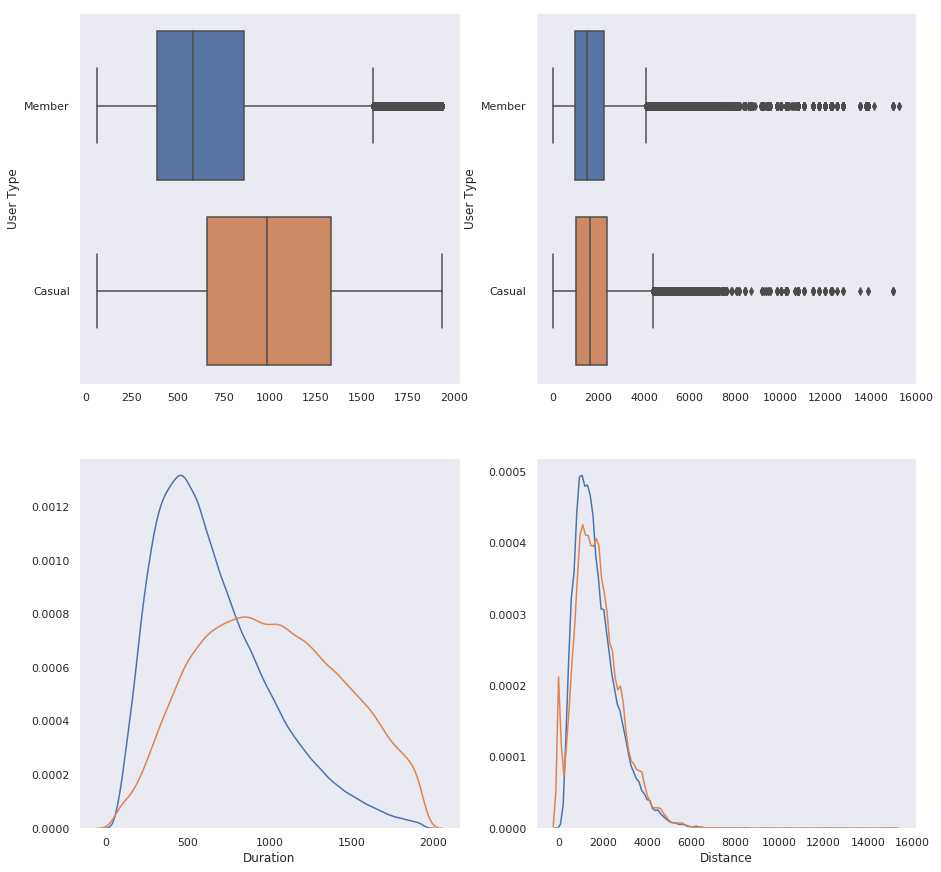

In [11]:
sns.set_style('dark')

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))

for i, col in enumerate(['Duration', 'Distance']):
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

plt.savefig('./visualization/distributions.png')

In [12]:
ridership = df.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'User Type'])['Id'].nunique().reset_index().sort_values('User Type', ascending=False)

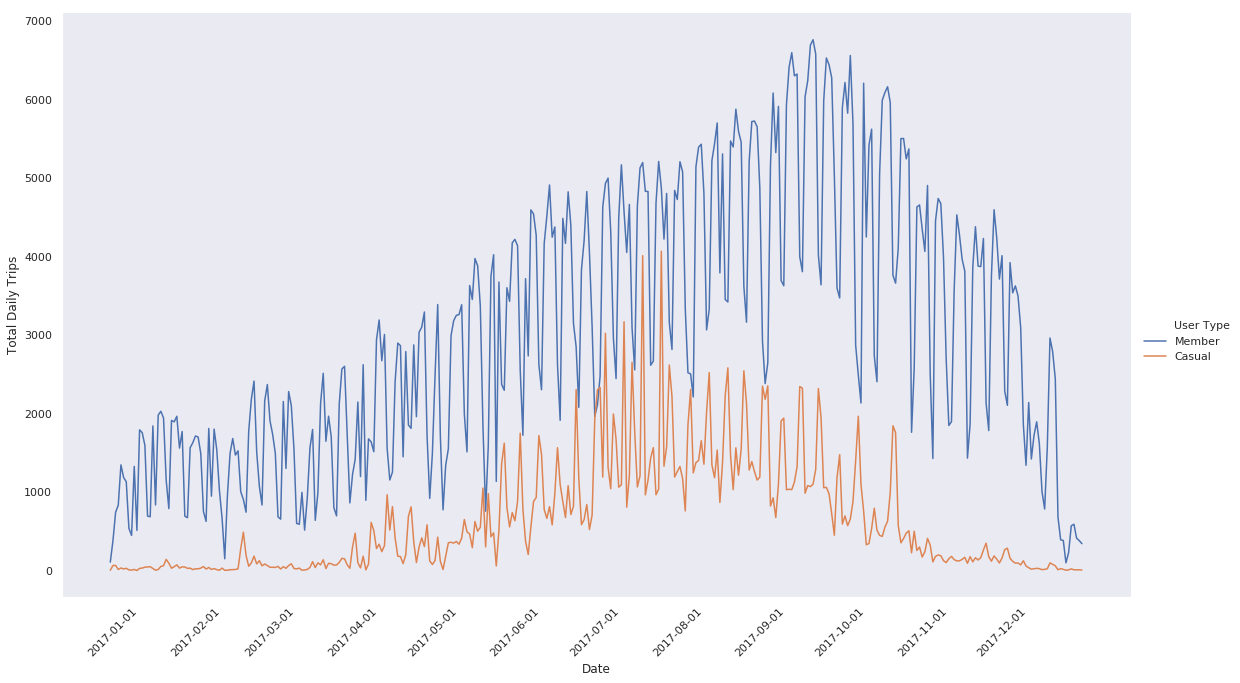

In [14]:
p = sns.relplot(x='Date', y='Id', hue='User Type', data=ridership, kind='line', height=9, aspect=16/9.)
p.ax.set_ylabel('Total Daily Trips')
p.ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in p.ax.get_xticklabels()], rotation=45)

plt.savefig('./visualization/ridership.png')

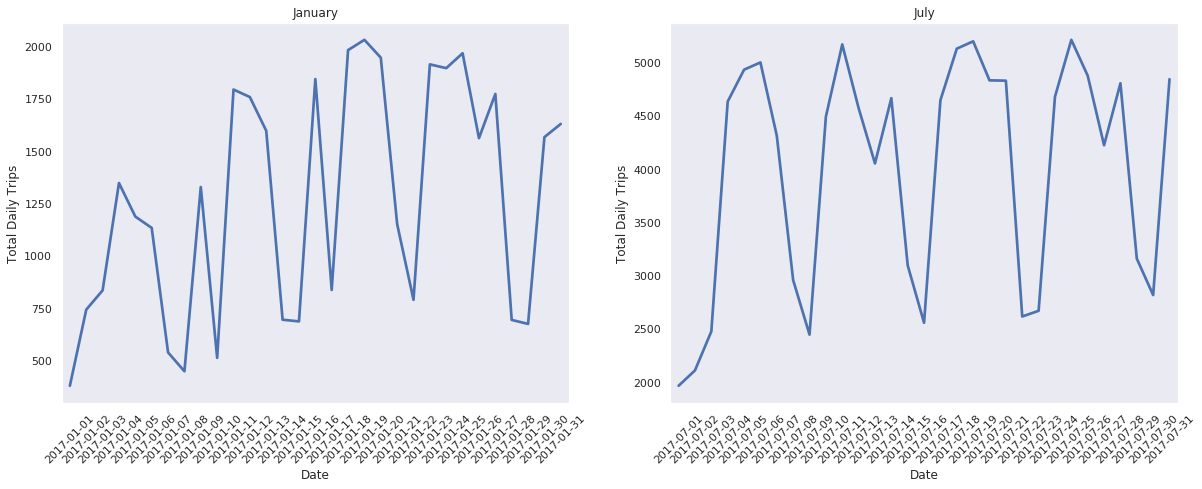

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for ax, m in zip(axes, ['January', 'July']):
    sns.pointplot(x='Date', y='Id', data=ridership[(ridership['Month']==m)&(ridership['User Type']=='Member')].groupby('Date')['Id'].sum().reset_index(), ax=ax, markers='')
    
    ax.set_title(m)
    ax.set_ylabel('Total Daily Trips')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('./visualization/ridership_selection.png')

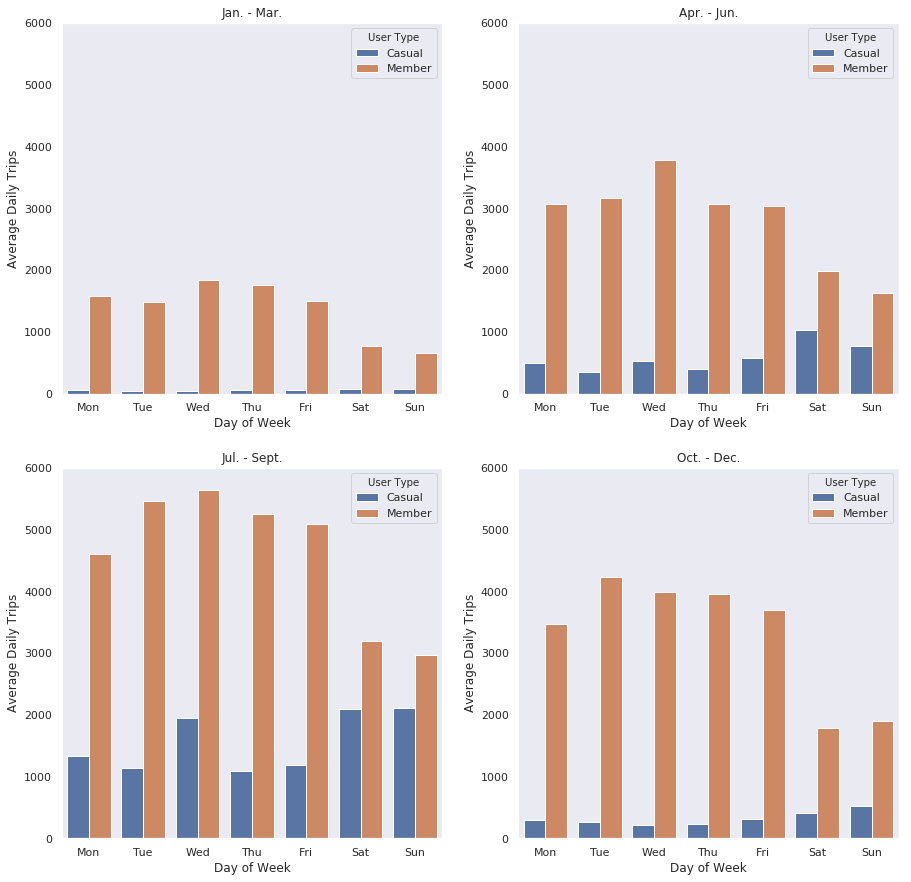

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = np.array(axes).flatten()
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.']


for q, ax in zip(sorted(ridership['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    ax.set_ylim(0, 6000)
    sns.barplot(x='Day of Week', 
                y='Id', 
                hue='User Type', 
                data=ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index(), ax=ax)
    ax.set_ylabel('Average Daily Trips')

plt.savefig('./visualization/quarterly.png')

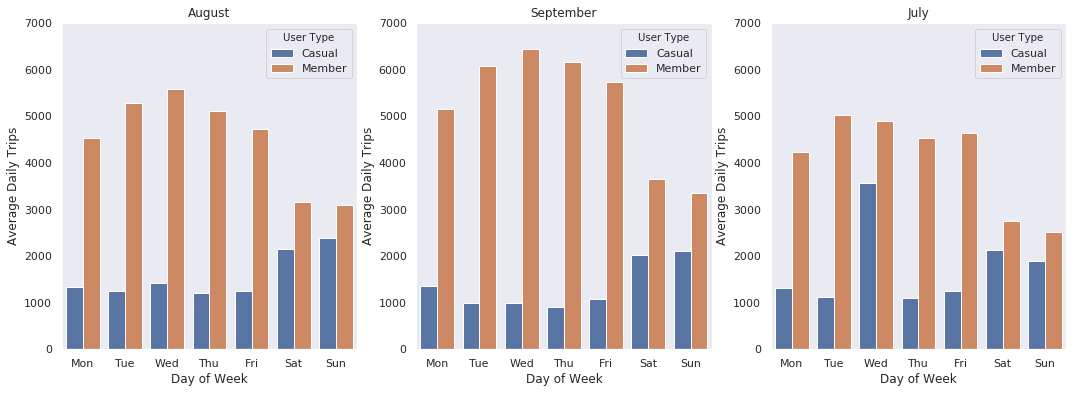

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = np.array(axes).flatten()

for m, ax in zip(ridership[ridership['Quarter']==3]['Month'].unique(), axes):
    ax.set_title(m)
    ax.set_ylim(0, 7000)
    sns.barplot(x='Day of Week', 
                y='Id', 
                hue='User Type', 
                data=ridership[ridership['Month']==m].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index(), ax=ax)
    ax.set_ylabel('Average Daily Trips')
plt.savefig('./visualization/third_quarter.png')

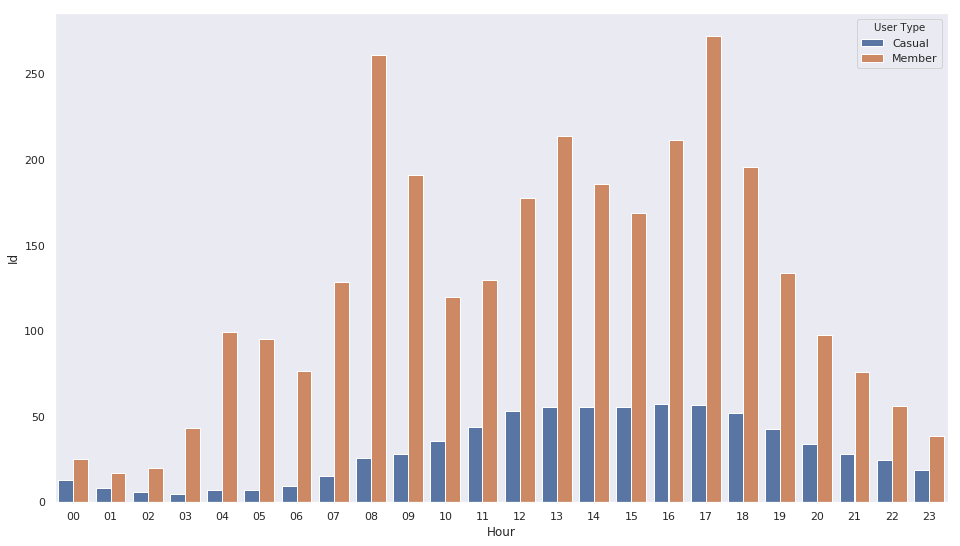

In [23]:
data = df.groupby(['Date', 'Hour', 'User Type'])['Id'].nunique().groupby(['Hour', 'User Type']).mean().reset_index()

fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(x='Hour', y='Id', hue='User Type', data=data, ax=ax)
plt.savefig('./visualization/hourly.png')

In [24]:
weather = pd.read_csv('./data/weather.csv', header=22)
weather.columns = [re.sub(r'\([^()]*\)', '', x).strip() if x != 'Date/Time' else 'Date' for x in weather.columns]

In [25]:
data = df.groupby(['Date', 'User Type'])['Id'].nunique().to_frame().pivot_table(index='Date', columns='User Type').reset_index()
data.columns = ['Date', 'Casual Trips', 'Member Trips']

data = data.merge(weather[['Date', 'Mean Temp', 'Total Precip']], on='Date', how='inner')

/home/dottyz/miniconda3/envs/open-data/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dottyz/miniconda3/envs/open-data/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


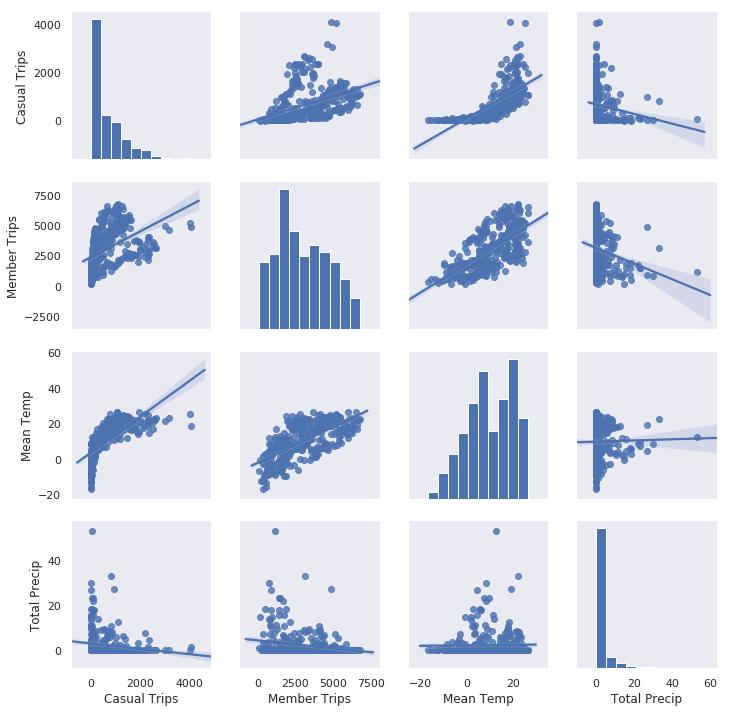

In [26]:
g = sns.pairplot(data, kind='reg')
g.fig.set_size_inches(10, 10)

g.savefig('./visualization/pair.png')

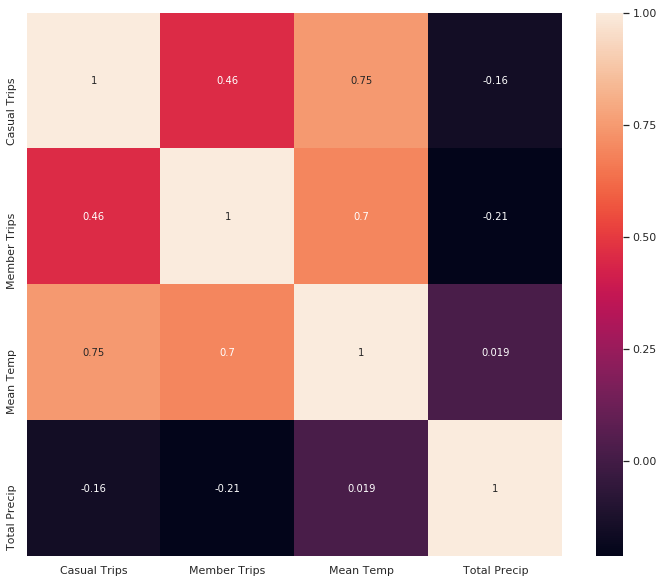

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True)

plt.savefig('./visualization/heatmap.png')

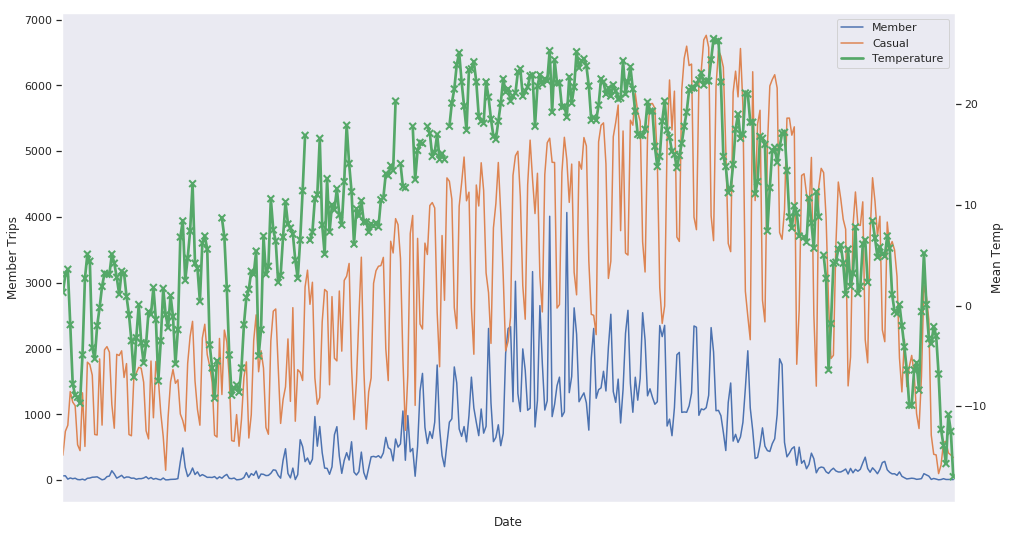

In [57]:
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()
palette = sns.color_palette()
lines = []

for i, user_type in enumerate(['Casual Trips', 'Member Trips']):
    sns.lineplot(x='Date', y=user_type, data=data, ax=ax, color=palette[i], markers='')
    
sns.pointplot(x='Date', y='Mean Temp', data=data, ax=ax2, color=palette[2], markers='x')

ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)
ax.legend(handles=ax.lines + ax2.lines, labels=['Member', 'Casual', 'Temperature'])
plt.savefig('./visualization/temperature.png')

In [27]:
data = data.sort_values('Mean Temp').dropna().reset_index(drop=True)

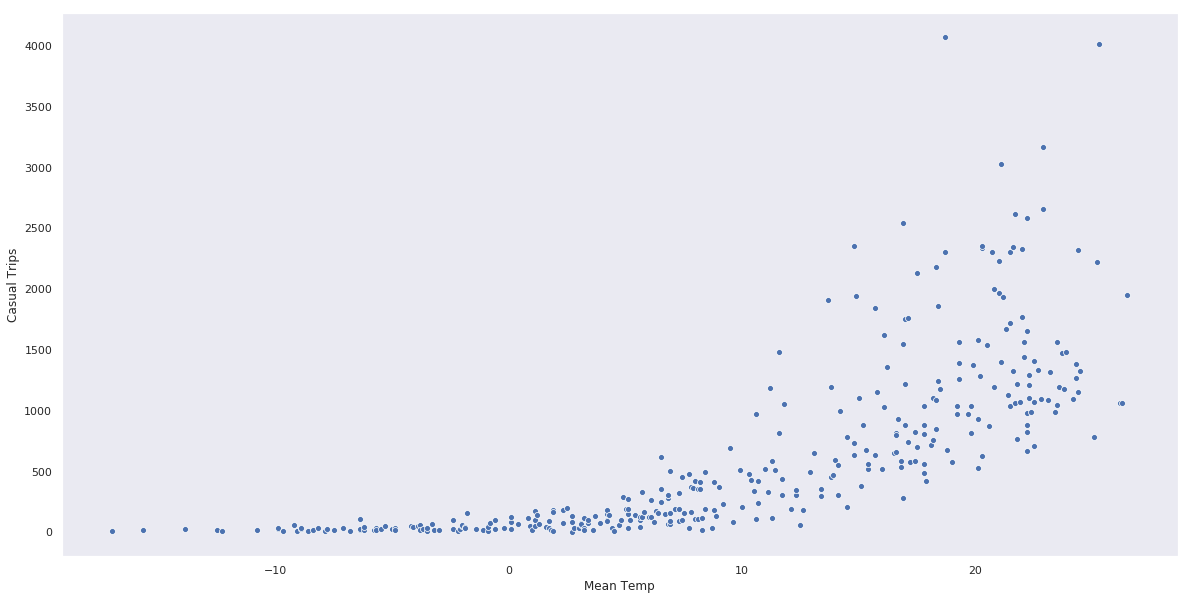

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x='Mean Temp', y='Casual Trips', data=data)
plt.savefig('./visualization/fit_0.png')

In [29]:
from kneed import KneeLocator
from scipy.optimize import curve_fit


def linear(x, m, b):
    return m*x + b

def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)

def exp_growth(x, a, b, c):
    return a * np.exp(-b * x) + c

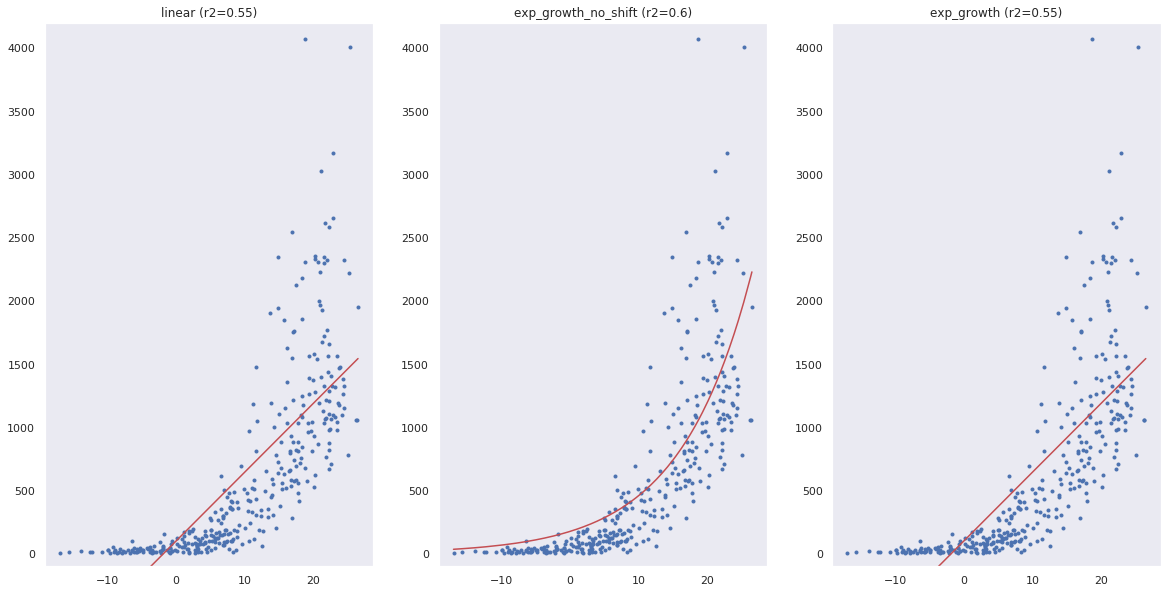

In [30]:
x = data['Mean Temp'].values
y = data['Casual Trips'].values

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, func in zip(axes, [linear, exp_growth_no_shift, exp_growth]):
    popt, pcov = curve_fit(func, x, y, maxfev=2000)
    y_fit = func(x, *popt)
    
    r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

    ax.plot(x, y, '.')
    ax.plot(x, y_fit, 'r-')
    ax.set_ylim(-100, 4200)
    ax.set_title('{0} (r2={1})'.format(func.__name__, np.round(r2, 2)))

plt.savefig('./visualization/fig_1.png')

In [31]:
popt, pcov = curve_fit(exp_growth_no_shift, x, y, maxfev=2000)

kneedle = KneeLocator(x=x, y=exp_growth_no_shift(x, *popt), curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.1


In [32]:
def logistic_growth(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

In [33]:
data['Cummulative Trips'] = data['Casual Trips'].cumsum()
data['Percentage Trips'] = data['Cummulative Trips'] / data['Casual Trips'].sum()

In [34]:
x = data['Mean Temp'].values
y = data['Percentage Trips'].values

popt, pcov = curve_fit(logistic_growth, x, y, maxfev=2000)
y_fit = logistic_growth(x, *popt)

In [35]:
kneedle = KneeLocator(x=x, y=y_fit, curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.0


In [36]:
for idx, val in enumerate(x):
    if val > knee_start:
        break
        
kneedle = KneeLocator(x=x[idx:], y=y_fit[idx:], curve='concave', direction='increasing')
knee_end = kneedle.knee

print(knee_end)

21.6


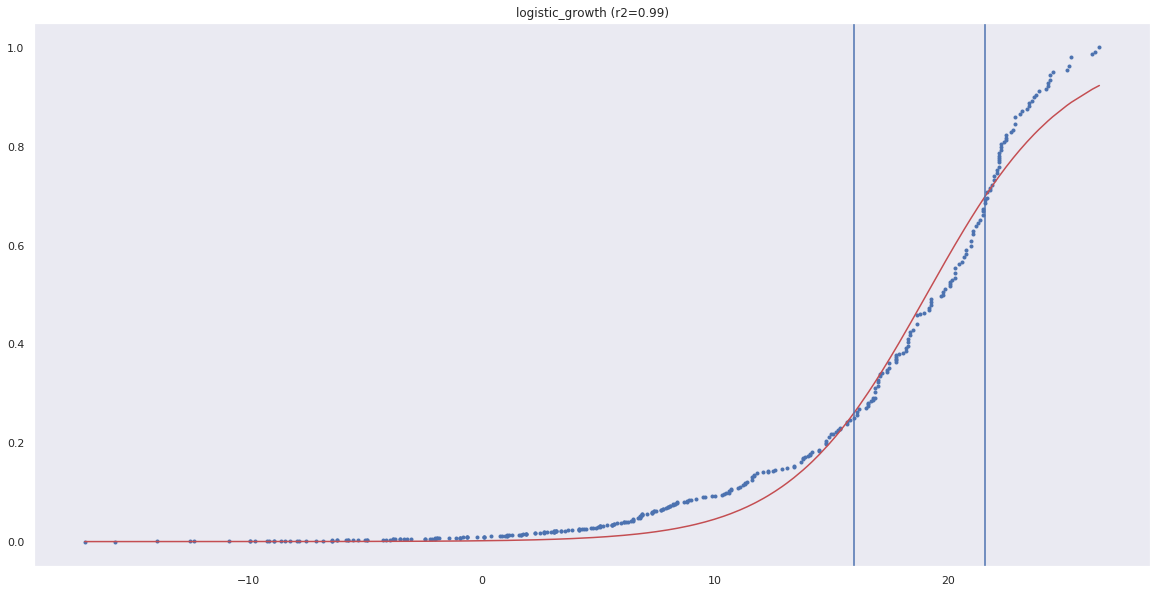

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

ax.plot(x, y, '.')
ax.plot(x, y_fit, 'r-')
ax.axvline(knee_start)
ax.axvline(knee_end)
ax.set_title('{0} (r2={1})'.format('logistic_growth', np.round(r2, 2)))

plt.savefig('./visualization/fit_3.png')

In [38]:
knee_end, knee_start

(21.6, 16.0)